In [6]:
import pyvista as pv
import numpy as np
from scipy.sparse import csr_matrix

In [ ]:
def make_spheres_radiuses_set(nsub=4):
    sphere = pv.Icosphere(radius=1, nsub=nsub)  # More uniform

    points = sphere.points.astype(np.float64)
    faces = sphere.faces.reshape(-1, 4)[:, 1:]

    n_points = len(points)
    edge_set = set()
    rows, cols, dists = [], [], []
    edge_lengths = []

    for tri in faces:
        for i in range(3):
            a, b = tri[i], tri[(i + 1) % 3]
            edge = tuple(sorted((a, b)))
            if edge not in edge_set:
                edge_set.add(edge)
                dist = np.linalg.norm(points[a] - points[b])
                edge_lengths.append(dist)  
                rows.extend([a, b])
                cols.extend([b, a])
                dists.extend([dist, dist])

    graph = csr_matrix((dists, (rows, cols)), shape=(n_points, n_points))
    h = np.mean(edge_lengths)
    
    radiuses = ((np.arange(1, 16) / 10) / h)
    nsub_radises = [(r, nsub) for r in radiuses] 

    return nsub_radises

make_spheres_radiuses_set(2)

In [ ]:
for i in range(1, 6):
    graph, faces, points, sphere, h = make_sphere(radius=1,nsub=i)
    print(f"Sphere with nsub={i}:")
    print(f"Number of points: {len(points)}")
    print(f"Number of faces: {len(faces)}")
    print(f"Average edge length: {h:.2f}")
    print()

/home/omer.trinin/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


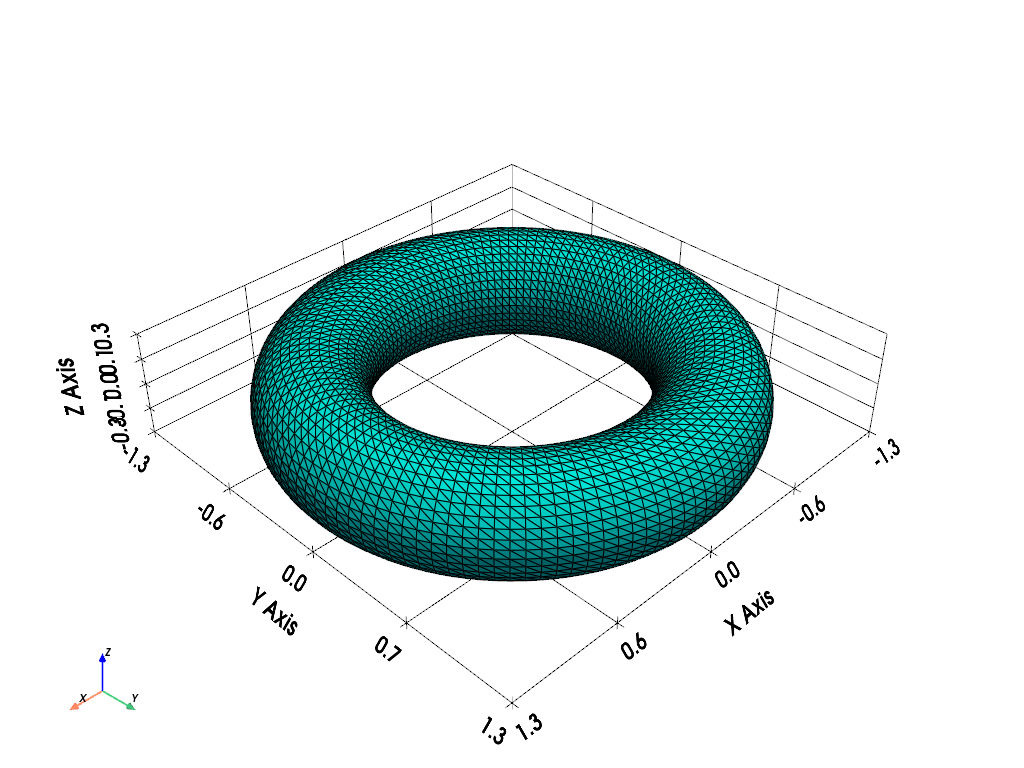

h: 0.05722225084900856


In [ ]:
import torch
import heapq
import pyvista as pv
import numpy as np
from collections import deque
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.sparse import csr_matrix
from models.sphere_models import SpherePointNetRing, SpherePointNetRingFeatureExtractionFirstRing, SpherePointNetRingAttention, SpherePointNetRingAttentionAndConvolution
from pyvista.core.utilities.parametric_objects import surface_from_para
from vtkmodules.vtkCommonComputationalGeometry import vtkParametricTorus


global_local_solver = None
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



def make_torus(ring_radius=1.0, cross_section_radius=0.3, u_res=60, v_res=20):
    torus_func = vtkParametricTorus()
    torus_func.SetRingRadius(ring_radius)
    torus_func.SetCrossSectionRadius(cross_section_radius)

    torus = surface_from_para(torus_func, u_res, v_res)

    points = torus.points.astype(np.float32)
    faces = torus.faces.reshape(-1, 4)[:, 1:]

    n_points = len(points)
    edge_set = set()
    rows, cols, dists = [], [], []
    edge_lengths = []

    for tri in faces:
        for i in range(3):
            a, b = tri[i], tri[(i + 1) % 3]
            edge = tuple(sorted((a, b)))
            if edge not in edge_set:
                edge_set.add(edge)
                dist = np.linalg.norm(points[a] - points[b])
                edge_lengths.append(dist)
                rows.extend([a, b])
                cols.extend([b, a])
                dists.extend([dist, dist])

    graph = csr_matrix((dists, (rows, cols)), shape=(n_points, n_points))
    h = np.mean(edge_lengths)

    return graph, faces, points, torus, h



def make_sphere(radius=1.0, nsub=3):
    # sphere = pv.Sphere(radius=radius, theta_resolution=theta_resolution//2, phi_resolution=phi_resolution)
    sphere = pv.Icosphere(radius=radius, nsub=nsub)  # More uniform

    points = sphere.points.astype(np.float32)
    faces = sphere.faces.reshape(-1, 4)[:, 1:]

    n_points = len(points)
    edge_set = set()
    rows, cols, dists = [], [], []
    edge_lengths = []

    for tri in faces:
        for i in range(3):
            a, b = tri[i], tri[(i + 1) % 3]
            edge = tuple(sorted((a, b)))
            if edge not in edge_set:
                edge_set.add(edge)
                dist = np.linalg.norm(points[a] - points[b])
                edge_lengths.append(dist)  
                rows.extend([a, b])
                cols.extend([b, a])
                dists.extend([dist, dist])

    graph = csr_matrix((dists, (rows, cols)), shape=(n_points, n_points))
    h = np.mean(edge_lengths)

    return graph, faces, points, sphere, h

def plot_errors(h_values, errors_regular_FMM, errors_saar_model):
    plt.figure()
    plt.loglog(h_values, errors_regular_FMM, marker='o', label='Regular FMM')
    plt.loglog(h_values, errors_saar_model, marker='s', label='Saar Model')
    plt.xlabel('Mean edge length h')
    plt.ylabel('L1 Loss')
    plt.title('Convergence Plot (Log-Log)')
    plt.grid(True, which='both')
    plt.legend()
    plt.show()


def get_3_ring_visited_neighbors(p, graph, status, u, points):
    visited = []
    queue = deque([(p, 0)])  # (node, depth)
    seen = set([p])
    
    while queue:
        current, depth = queue.popleft()
        if depth > 3:
            continue
        if status[current] == 'Visited' and current != p:
            point_xyz = tuple(points[current])  # (x, y, z)
            visited.append([point_xyz[0], point_xyz[1], point_xyz[2], u[current]])
        for neighbor in graph[current].nonzero()[1]:
            if neighbor not in seen:
                seen.add(neighbor)
                queue.append((neighbor, depth + 1))

    return torch.tensor(visited, dtype=torch.float32).T  # Shape: [4, N]


def local_solver_dijkstra(p, graph, status, u, points):
    min_val = np.inf
    for neighbor in graph[p].nonzero()[1]:
        if status[neighbor] == 'Visited':
            candidate = u[neighbor] + graph[p, neighbor]
            if candidate < min_val:
                min_val = candidate
    return min_val


def local_solver_ron(p, graph, status, u, points):
    neighbors = graph[p].nonzero()[1]
    visited_neighbors = [n for n in neighbors if status[n] == 'Visited']

    if not visited_neighbors:
        return u[p] 

    min_u = min(u[n] + np.linalg.norm(points[p] - points[n]) for n in visited_neighbors)

    best_u = min_u
    for i in range(len(visited_neighbors)):
        for j in range(i + 1, len(visited_neighbors)):
            a, b = visited_neighbors[i], visited_neighbors[j]
            ua, ub = u[a], u[b]
            pa, pb, pp = points[a], points[b], points[p]
            dab = np.linalg.norm(pa - pb)

            # Upwind Eikonal solver
            if abs(ua - ub) >= dab:
                continue  # upwind condition not met, use min

            s = (ua + ub + np.sqrt(2 * dab**2 - (ua - ub)**2)) / 2
            if s < best_u:
                best_u = s

    return best_u


def local_solver_model_ring3(p, graph, status, u, points): #fast
    visited_neighbors = get_3_ring_visited_neighbors(p, graph, status, u, points).to(device)  # shape: (4, N) with N ≤ 90
    num_valid = visited_neighbors.shape[1]
    visited_neighbors_padded = F.pad(visited_neighbors, (0, 90 - num_valid), "constant", 0).unsqueeze(0)  # (1, 4, 90)
    mask = torch.zeros(90, dtype=torch.float32)
    mask[:num_valid] = 1
    mask = mask.unsqueeze(0)  # (1, 90)
    point_xyz = torch.tensor(points[p], dtype=torch.float32).unsqueeze(0)  # (1, 3)
    visited_neighbors_padded = visited_neighbors_padded.to(device)
    point_xyz = point_xyz.to(device)
    mask = mask.to(device)
    
    distance_estimation = global_local_solver(visited_neighbors_padded, point_xyz, mask).item()
    return distance_estimation


# def FMM_with_local_solver(graph: csr_matrix, points, source_points, local_solver): NOT REAL!
#     n_points = graph.shape[0]
#     u = np.full(n_points, np.inf)
#     status = np.full(n_points, 'Unvisited', dtype=object)
#     heap = []  # (u value, point index)

#     for p in source_points:
#         u[p] = 0
#         status[p] = 'Visited'
#         for neighbor in graph[p].nonzero()[1]:
#             if status[neighbor] == 'Unvisited':
#                 status[neighbor] = 'Wavefront'
#                 heapq.heappush(heap, (u[p] + graph[p, neighbor], neighbor))

#     while heap:
#         _, p = heapq.heappop(heap)
#         if status[p] == 'Visited':
#             continue 

#         u[p] = local_solver(p, graph, status, u, points)
#         status[p] = 'Visited'

#         for neighbor in graph[p].nonzero()[1]:
#             if status[neighbor] == 'Unvisited' or status[neighbor] == 'Wavefront': #Omer added
#                 if status[neighbor] == 'Unvisited':
#                     status[neighbor] = 'Wavefront'
#                     u[neighbor] = u[p] + graph[p, neighbor]
#                 else:
#                     new_distance = u[p] + graph[p, neighbor]
#                     if new_distance < u[neighbor]:
#                         u[neighbor] = new_distance
#                 heapq.heappush(heap, (u[p] + graph[p, neighbor], neighbor))
#     return u


def FMM_with_local_solver(graph: csr_matrix, points, source_points, local_solver):  #Implementation of the "real" FMM
    n_points = graph.shape[0]
    u = np.full(n_points, np.inf)
    status = np.full(n_points, 'Unvisited', dtype=object)
    heap = []  # (u value, point index)

    for p in source_points:
        u[p] = 0
        status[p] = 'Visited'
        for neighbor in graph[p].nonzero()[1]:
            if status[neighbor] == 'Unvisited':
                status[neighbor] = 'Wavefront'
                heapq.heappush(heap, (u[p] + graph[p, neighbor], neighbor))

    while heap:
        _, p = heapq.heappop(heap)
        if status[p] == 'Visited':
            continue

        u[p] = local_solver(p, graph, status, u, points)
        status[p] = 'Visited'

        for neighbor in graph[p].nonzero()[1]:
            if status[neighbor] == 'Unvisited':
                status[neighbor] = 'Wavefront'
                u[neighbor] = local_solver(neighbor, graph, status, u, points)
                heapq.heappush(heap, (u[p] + graph[p, neighbor], neighbor))
            elif status[neighbor] == 'Wavefront':
                new_distance = local_solver(neighbor, graph, status, u, points)
                if new_distance < u[neighbor]:
                    u[neighbor] = new_distance
                    heapq.heappush(heap, (u[p] + graph[p, neighbor], neighbor))
    return u

def make_spheres_radiuses_set(nsub=3, start_h=0.1, end_h=1.6, step=0.1):   #to calculate desired h and get r,nsub
    graph, faces, points, sphere, h = make_sphere(radius=1, nsub=nsub)
    radiuses = (np.arange(start_h, end_h, step) / h)  #here we change
    nsub_radises = [(r, nsub) for r in radiuses] 
    return nsub_radises

def true_distances(points, radius, source_idx):
    points = points.astype(np.float64)
    norm_points = points / np.linalg.norm(points, axis=1, keepdims=True)
    norm_source = norm_points[source_idx:source_idx+1]
    cosines = np.einsum('ij,ij->i', norm_points, norm_source)
    cosines = np.clip(cosines, -1.0, 1.0)
    dists = radius * np.arccos(cosines)
    dists[source_idx] = 0.0
    return dists


nsub_radius = make_spheres_radiuses_set(nsub=3, start_h=0.1, end_h=0.2, step=0.1) 
h_vals = []
l1_errors_base = []
l1_errors_saar_model = []#
np.random.seed(0)
for n_r in nsub_radius:
    radius = n_r[0]
    nsub = n_r[1]
    #points = coordinates of each point
    #graph = (number of node a, number of node b, edge length between a and b)
    # graph, faces, points, sphere, h = make_sphere(radius=radius, nsub=nsub) #radius=10, nsub=r
    ########
    graph, faces, points, torus, h = make_torus(ring_radius=1.0, cross_section_radius=0.3, u_res=120, v_res=40)
    torus.plot(show_edges=True, color='cyan', show_grid=True)
    ########
    source_idxs = np.random.choice(len(points), size=5, replace=False) #randomly select points from the sphere
    print(f"h: {h}")

    #Load the local solver (the model)
    local_solver = SpherePointNetRing()
    local_solver = SpherePointNetRingFeatureExtractionFirstRing()
    local_solver = SpherePointNetRingAttention()
    local_solver = SpherePointNetRingAttentionAndConvolution()
    checkpoint = torch.load("checkpoints/sphere_pointnet_epoch9_loss6.9316201177493276e-06.pt", map_location=device)
    local_solver.load_state_dict(checkpoint["model_state_dict"])
    local_solver = local_solver.to(device)
    local_solver.eval()
    global_local_solver = local_solver

    l1_losses_base = []
    l1_losses_saar_model = []
    for source_idx in source_idxs:
        distances_base = FMM_with_local_solver(graph, points, [source_idx], local_solver_dijkstra)
        distances_saar_model = FMM_with_local_solver(graph, points, [source_idx], local_solver_model_ring3)
        true_geodesic = true_distances(points, radius, source_idx)
        #######
        true_geodesic = distances_base
        torus["Distance"] = distances_saar_model
        torus.plot(scalars="Distance", cmap="viridis", show_edges=False)
        torus["Distance"] = distances_base
        torus.plot(scalars="Distance", cmap="viridis", show_edges=False)
        #######
        l1_losses_base.append(np.mean(np.abs(distances_base - true_geodesic)))
        l1_losses_saar_model.append(np.mean(np.abs(distances_saar_model - true_geodesic)))
        #sphere["GeodesicDistance"] = true_geodesic
        #sphere.plot(scalars="GeodesicDistance", cmap="viridis", show_edges=False)
        #sphere["GeodesicDistance"] = distances_regular_FMM
        #sphere.plot(scalars="GeodesicDistance", cmap="viridis", show_edges=False)
        #sphere["GeodesicDistance"] = distances_saar_model
        #sphere.plot(scalars="GeodesicDistance", cmap="viridis", show_edges=False)

    l1_loss_regular_FMM = np.mean(l1_losses_base)
    l1_loss_saar_model = np.mean(l1_losses_saar_model)
    l1_errors_base.append(l1_loss_regular_FMM)
    l1_errors_saar_model.append(l1_loss_saar_model)
    h_vals.append(h)


average_slope_regular_FMM = np.mean(np.diff(np.log(l1_errors_base)) / np.diff(np.log(h_vals)))
average_slope_saar_model = np.mean(np.diff(np.log(l1_errors_saar_model)) / np.diff(np.log(h_vals)))
print(f"h values: {h_vals}")
print(f"Average slope base: {average_slope_regular_FMM:.3f}")
print(f"Average slope saar model: {average_slope_saar_model:.3f}")
plot_errors(h_vals, l1_errors_base, l1_errors_saar_model)
print(f"l1_errors_base: {l1_errors_base}")
print(f"l1_errors_saar_model: {l1_errors_saar_model}")


/home/omer.trinin/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


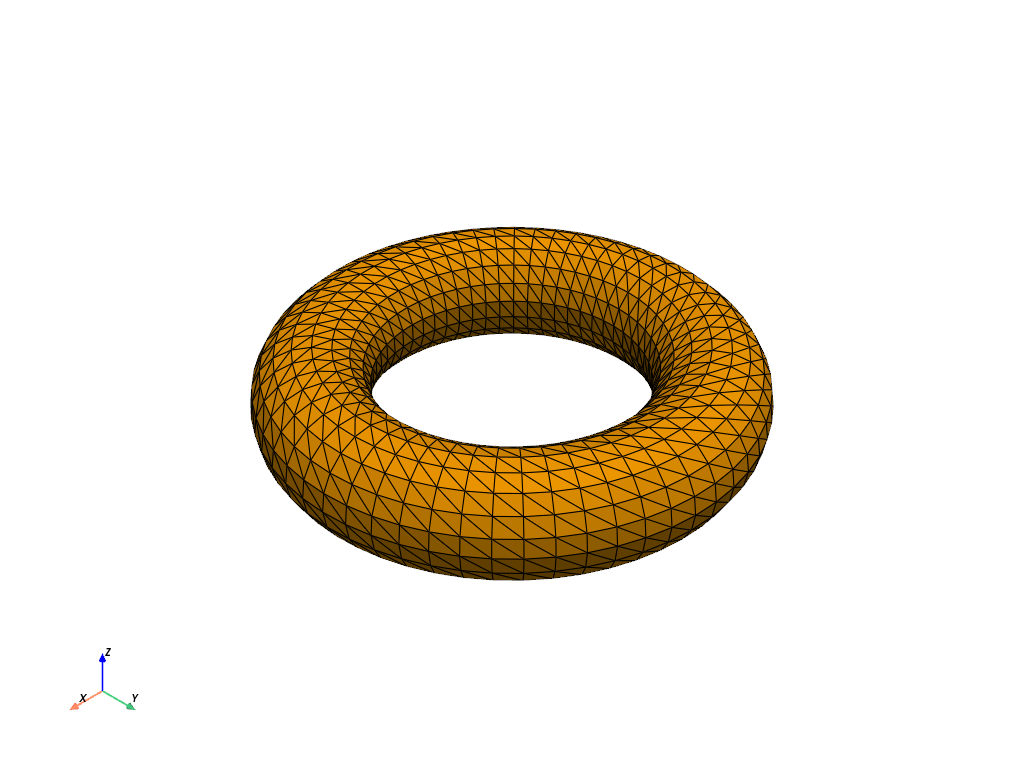

/home/omer.trinin/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


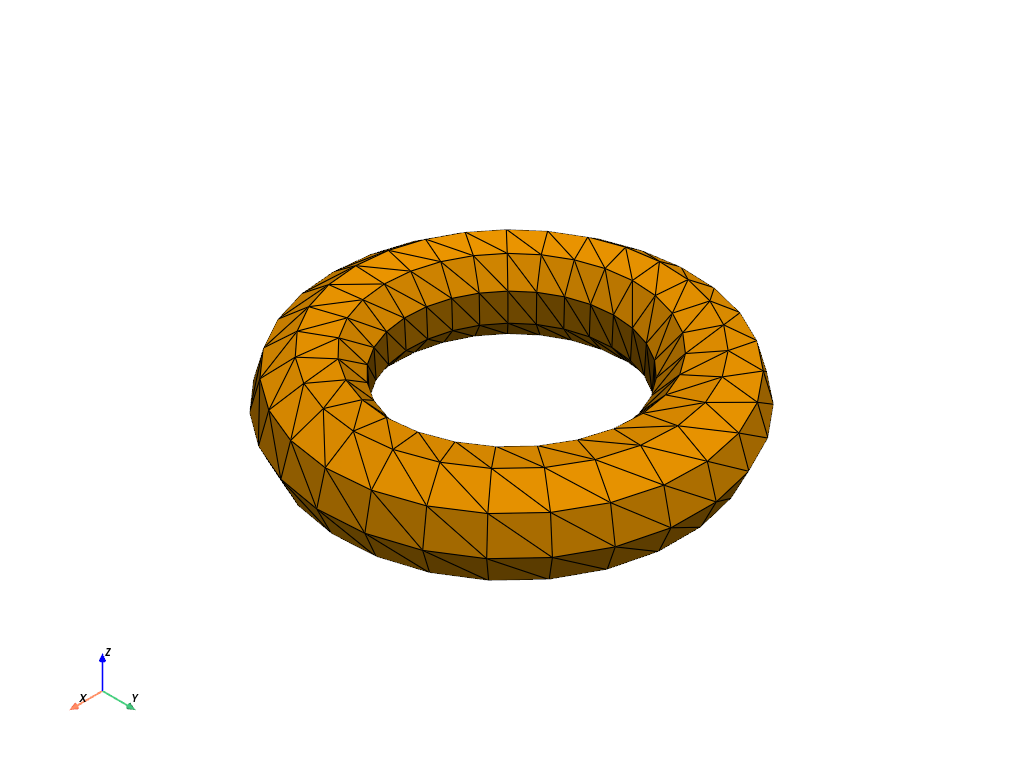

[0.         1.2298133  0.19283628]
[0.        1.0520945 0.2954423]
[0.         0.85       0.25980762]
[0.         0.7180922  0.10260604]
[ 0.          0.7180922  -0.10260604]
[ 0.          0.85       -0.25980762]
[ 0.         1.0520945 -0.2954423]
[ 0.          1.2298133  -0.19283628]
[0.27946156 1.2696067  0.        ]
[0.2643735  1.201061   0.19283628]
[0.22616921 1.027497   0.2954423 ]
[0.18272488 0.8301275  0.25980762]
[0.1543686  0.7013036  0.10260604]
[ 0.1543686   0.7013036  -0.10260604]
[ 0.18272488  0.8301275  -0.25980762]
[ 0.22616921  1.027497   -0.2954423 ]
[ 0.2643735   1.201061   -0.19283628]
[ 2.7946156e-01  1.2696067e+00 -7.3478811e-17]
[0.5458558 1.1798481 0.       ]
[0.5163852  1.1161484  0.19283628]
[0.44176298 0.9548551  0.2954423 ]
[0.35690573 0.77143914 0.25980762]
[0.3015191  0.65172285 0.10260604]
[ 0.3015191   0.65172285 -0.10260604]
[ 0.35690573  0.77143914 -0.25980762]
[ 0.44176298  0.9548551  -0.2954423 ]
[ 0.5163852   1.1161484  -0.19283628]
[ 5.4585582e-01 

In [51]:
import pyvista as pv
from pyvista.core.utilities.parametric_objects import surface_from_para
from vtkmodules.vtkCommonComputationalGeometry import vtkParametricTorus

def make_torus_with_surface_from_para(ring_radius=1.0, cross_section_radius=0.3, u_res=60, v_res=20):
    torus_func = vtkParametricTorus()
    torus_func.SetRingRadius(ring_radius)
    torus_func.SetCrossSectionRadius(cross_section_radius)

    torus = surface_from_para(torus_func, u_res, v_res)
    return torus

# Example usage
torus1 = make_torus_with_surface_from_para(u_res=60, v_res=20)
torus1.plot(show_edges=True, color='orange')
torus2 = make_torus_with_surface_from_para(u_res=30, v_res=10)
torus2.plot(show_edges=True, color='orange')


m1 = [tuple(p) for p in torus1.points]  # Convert points to tuples for comparison
for p in torus2.points:
    if tuple(p) not in m1:  # Check if the tuple of the point exists in m1
        print(p)

/home/omer.trinin/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


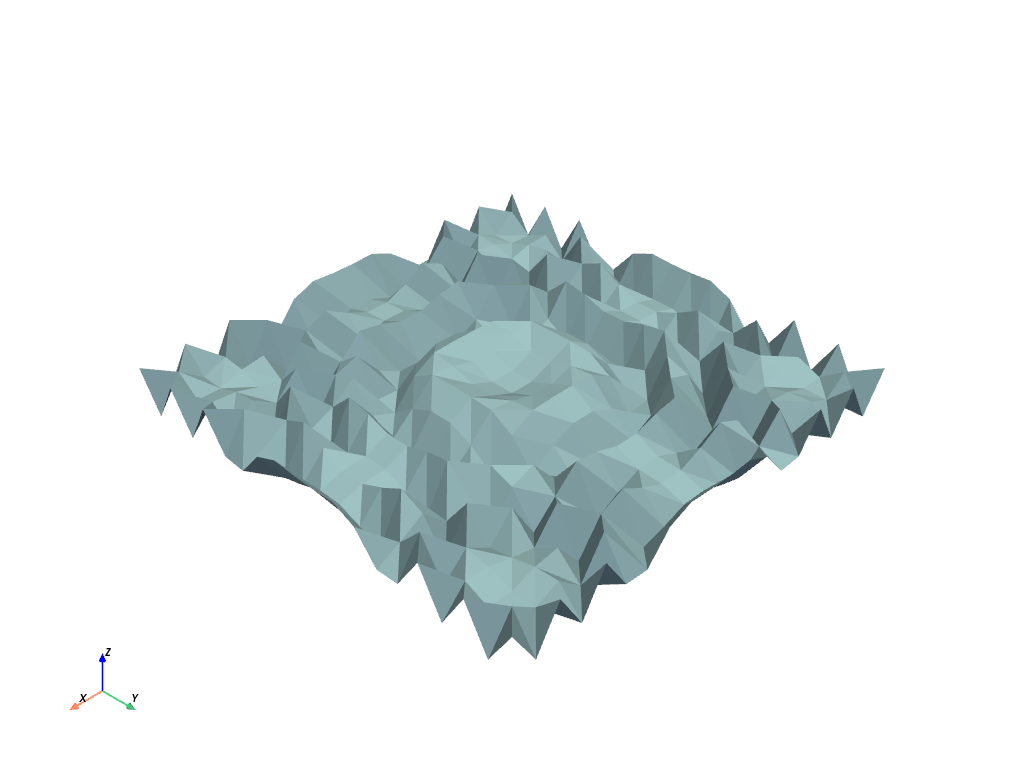

In [89]:
import numpy as np
import pyvista as pv
# Create a 2D grid in x and y
x = y = np.linspace(-10, 10, 20)
x, y = np.meshgrid(x, y)

# Define z as the function of x and y
z = np.sin(0.2 * (x**2 + y**2))

# Flatten and stack points
points = np.c_[x.ravel(), y.ravel(), z.ravel()]
cloud = pv.PolyData(points)

# Create a 2D triangulated surface
tri_mesh = cloud.delaunay_2d()

# Plot it
tri_mesh.plot()


In [1]:
import torch
import heapq
import pyvista as pv
import numpy as np
from collections import deque
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.sparse import csr_matrix
from models.sphere_models import SpherePointNetRing, SpherePointNetRingFeatureExtractionFirstRing, SpherePointNetRingAttention, SpherePointNetRingAttentionAndConvolution

def make_sphere(radius=1.0, nsub=3):
    # sphere = pv.Sphere(radius=radius, theta_resolution=theta_resolution//2, phi_resolution=phi_resolution)
    sphere = pv.Icosphere(radius=radius, nsub=nsub)  # More uniform

    points = sphere.points.astype(np.float32)
    faces = sphere.faces.reshape(-1, 4)[:, 1:]

    n_points = len(points)
    edge_set = set()
    rows, cols, dists = [], [], []
    edge_lengths = []

    for tri in faces:
        for i in range(3):
            a, b = tri[i], tri[(i + 1) % 3]
            edge = tuple(sorted((a, b)))
            if edge not in edge_set:
                edge_set.add(edge)
                dist = np.linalg.norm(points[a] - points[b])
                edge_lengths.append(dist)  
                rows.extend([a, b])
                cols.extend([b, a])
                dists.extend([dist, dist])

    graph = csr_matrix((dists, (rows, cols)), shape=(n_points, n_points))
    h = np.mean(edge_lengths)

    return graph, faces, points, sphere, h

In [18]:
import pyvista as pv
import pygeodesic.geodesic as geodesic

# Create a high-res sphere
graph, faces, points, sphere, h = make_sphere(nsub=3, radius=1)
print(h)
# Extract vertices and triangle indices
vertices = sphere.points
faces = sphere.faces.reshape((-1, 4))[:, 1:]  # Remove leading '3' from each face definition

# Initialize geodesic solver
geoalg = geodesic.PyGeodesicAlgorithmExact(vertices, faces)

# Choose source vertex
source_index = 0

# Compute distances from source to all vertices
distances, _ = geoalg.geodesicDistances([source_index], None)

# distances is a NumPy array with the geodesic distance from source_index to each vertex
print(np.max(distances))  # Vector of shape (n_vertices,)


0.15008418
3.1338904742989175


In [15]:
import os
import sys
import numpy as np
from fast_matching_python.fast_marching import fast_marching

def compute_mesh_geodesics(V: np.ndarray, F: np.ndarray) -> np.ndarray:
    tmp_off = "/tmp/mesh.off"
    with open(tmp_off, "w") as f:
        f.write("OFF\n")
        f.write(f"{len(V)} {len(F)} 0\n")
        for vert in V:
            f.write(f"{vert[0]} {vert[1]} {vert[2]}\n")
        for face in F:
            f.write(f"3 {face[0]} {face[1]} {face[2]}\n")

    D = fast_marching.fast_marching(data_dir=tmp_off, source_index=0, verbose=True)  # if 'source' is the correct argument name

    return np.asarray(D)




graph, faces, vertices, sphere, h = make_sphere(radius=1, nsub=5)
distances = compute_mesh_geodesics(vertices, faces)

print()
print("Pairwise geodesic distance matrix:")
print(np.max(distances))


[                                                  ]                                                   ] 0%
Pairwise geodesic distance matrix:
3.1351016387409185


/home/omer.trinin/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


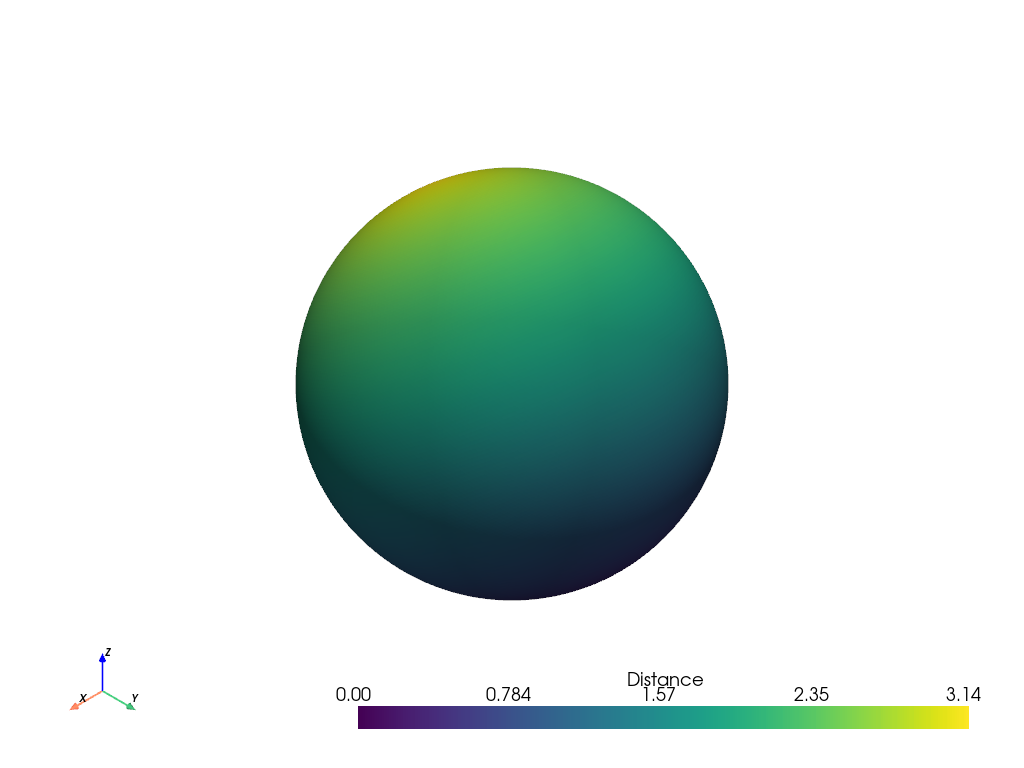

In [8]:
sphere["Distance"] = distances
sphere.plot(scalars="Distance", cmap="viridis", show_edges=False)